# Thermodynamically Compatible Finite Volume Scheme

We will consider finite-volume methods. These are popular in astrophysics because they are based on the integral form of the conservative equations and properly conserve mass, momentum, and energy. We will consider an Eulerian grid: the grid is fixed and the fluid moves through it. We will be explicit in time: the new solution depends only on the previous state.

## Importing Libraries

In [39]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import matplotlib.image as mlt
import scipy.optimize as optimize
import math

## Gauss Legendre Quadrature of order n (Not Used here)

In [40]:
# Recursive Generation of Legendre polynomial of order n

def Legendre(n, x):
  x = array(x)
  if(n == 0):
    return x*0+1.0
  elif(n == 1):
    return x
  else:
    return ((2.0*n-1.0)*x*Legendre(n-1, x) - (n-1)*Legendre(n-2, x))/n

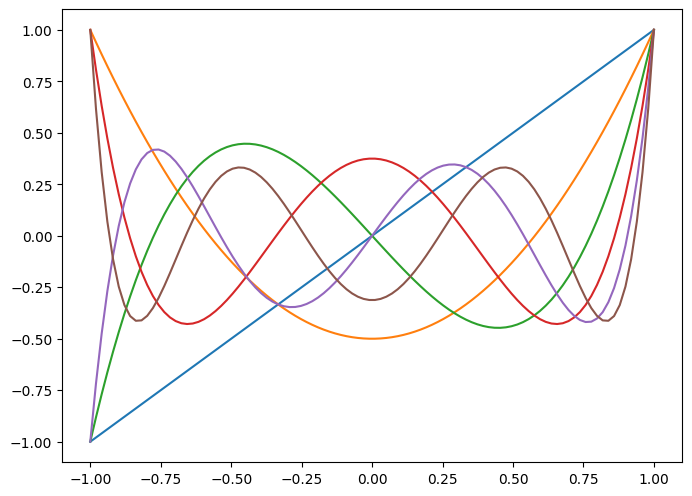

In [41]:
# Checking the Legendre Polynomial function

i = 1
x = linspace(-1,1,100)
xarr = array(x)

for i in range(1, 7):
  y = []
  for ele in x:
      # print(i, ele, Legendre(i, ele))
      y.append(Legendre(i, ele))
  yarr = array(y)
  plt.plot(xarr, yarr)
plt.show()

In [42]:
# Derivative of the Legendre polynomials

def der_Legendre(n, x):
  x = array(x);
  if(n == 0):
    return x*0
  elif(n == 1):
    return x*0+1.0
  else:
    return (n/(x**2-1.0)) * (x*Legendre(n, x) - Legendre(n-1, x))

In [43]:
# Finding the roots of the polynomial obtained using Newton-Raphson method

def roots_Legendre(poly_order, tolerance = 1e-7):
  if poly_order < 2:
    err = 1 # No roots can be found as it is a bad polynomial
  else:
    roots = []
    # The polynomials are alternatively even and odd functions. So, we need to
    # only half the number of roots.
    for i in range(1, (polyorder//2) + 1):
      x = cos(pi*(i - 0.25)/(poly_order+0.5))
      error = 10 * tolerance
      num_iters = 0
      while(error > tolerance) and (num_iters < 10000):
        dx = -Legendre(poly_order, x)/der_Legendre(poly_order, x)
        x = x + dx
        num_iters += 1
        error = abs(dx)
      if num_iters == 10000:
        print('Failed to convg')
      roots.append(x)

    # Now, we will use symmetry to get the other roots
    roots = array(roots)
    if(poly_order % 2 == 0):
      roots = concatenate((-1.0*roots, roots[::-1]))
    else:
      roots = concatenate((-1.0*roots, [0.0], roots[::-1]))
    
    err = 0 # we have successfully determined roots
    return [roots, err]


In [44]:
# Finding the weights coefficients

def weight_Legendre(poly_order):
  w = []
  [xis, err] = roots_Legendre(poly_order)
  if(err == 0):
    w = 2.0/((1.0-xis**2)*(der_Legendre(poly_order, xis) ** 2))
    err = 0
  else:
    err = 1 # no weights as we could not determine the roots
  
  return [w, xis, err]

In [45]:
# Finding the Gauss Legendre Quadrature 
# func : the function; a, b: upper & lower limits; poly_order: order of Legendre polynomial

def GaussLegendreQuadrature(func, poly_order, a, b):
  [ws, xs, err] = weight_Legendre(poly_order)
  if(err == 0):
    ans = (b-a) * 0.5 * sum(ws*func((b-a)*0.5*xs + (b+a)*0.5))
  else: # case of error
    err = 1
    ans = None
  return [ans, err]

In [46]:
# Integrand function i.e. the main function

def func(x):
  return exp(x)

In [47]:
# Running the code

polyorder = 5
[ws,xs,err] = weight_Legendre(polyorder)

if err==0:
	print("Order    : ", polyorder)
	print("Roots    : ", xs)
	print("Weights  : ", ws)
else:
	print("Roots/Weights evaluation failed")
 
# Integrating the function
[ans,err]=GaussLegendreQuadrature(func , polyorder, -3,3)
if err==0:
	print("Integral : ", ans)
else:
	print("Integral evaluation failed")

Order    :  5
Roots    :  [-0.90617985 -0.53846931  0.          0.53846931  0.90617985]
Weights  :  [0.23692689 0.47862867 0.56888889 0.47862867 0.23692689]
Integral :  20.035577718385444


## Euler Subsystem

We'll manage our 1-d grid via a class FVGrid. We will divide the domain into a number of zones (or volumes) that will store the state. To implement boundary conditions, we traditionally use ghost cells--extra cells added to each end of the domain. We use $lo$ and $hi$ to refer to the first and last zone in our domain.



![image](https://raw.githubusercontent.com/python-hydro/how_to_write_a_hydro_code/337a066405b47f9a31c8dd00ec833c3ba6742c3c//simplegrid_gc.png)

To make life easier, we'll have a simple class with indices that we use to index the fluid state arrays. We can pass this around and be sure that we are always accessing the correct fluid state.

In [48]:
class FluidVars:
    """A simple container that holds the integer indicies we will use to
    refer to the different fluid components"""
    def __init__(self, gamma=1.4, C=0.8):
        self.nvar = 3
    
        # conserved variables
        self.urho = 0
        self.umx = 1
        self.uener = 2
    
        # primitive variables
        self.qrho = 0
        self.qu = 1
        self.qp = 2
    
        # EOS gamma
        self.gamma = gamma
        
        # CFL number
        self.C = C

This is the main class for managing the finite-volume grid. In addition to holding coordinate information and knowing the bounds of the domain, it also can fill the ghost cells and give you a scratch array that lives on the same grid.

In [49]:
class FVGrid:
    """The main finite-volume grid class for holding our fluid state."""
    
    def __init__(self, nx, ng, xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        self.lo = ng
        self.hi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

    def scratch_array(self, nc=1):
        """ return a scratch array dimensioned for our grid """
        return np.squeeze(np.zeros((self.nx+2*self.ng, nc), dtype=np.float64))

    def fill_BCs(self, atmp, bc = 'not-per'):
        """ fill all ghost cells with zero-gradient boundary conditions """
        if bc == 'not-per':
          if atmp.ndim == 2:
              for n in range(atmp.shape[-1]):
                  atmp[0:self.lo, n] = atmp[self.lo, n]
                  atmp[self.hi+1:, n] = atmp[self.hi, n]            
          else:
              atmp[0:self.lo] = atmp[self.lo]
              atmp[self.hi+1:] = atmp[self.hi]
        if bc == 'per':
          if atmp.ndim == 2:
            for n in range(atmp.shape[-1]):
                atmp[0:self.lo, n] = atmp[self.hi, n]
                atmp[self.hi+1:, n] = atmp[self.hi, n]            
          else:
              atmp[0:self.lo] = atmp[self.hi]
              atmp[self.hi+1:] = atmp[self.hi]

We need to use the cell-averages to figure out what the fluid state is on the interfaces. We'll reconstruct the cell-averages as piecewise lines that give us the same average in the zone. We then follow these lines to the interfaces to define the left and right state at each interface.
Usually we work in terms of the primitive variables, $$ q = (\rho, u, p) $$ So, we first write a routine to do the algebraic transformation from conservative to primitive variables:
$$\rho = \rho$$
$$ u = \frac{\rho u}{\rho} $$
$$ p = ((\rho E) - \frac{1}{2} \frac{(\rho u)^{2}}{\rho})(γ - 1)$$

In [50]:
def cons_to_prim(grid, U):
    """take a conservative state U and return the corresponding primitive
    variable state as a new array."""
    v = FluidVars()
    q = grid.scratch_array(nc=v.nvar)

    q[:, v.qrho] = U[:, v.urho]
    q[:, v.qu] = U[:, v.umx]/U[:, v.urho]
    rhoe = U[:, v.uener] - 0.5*q[:, v.qrho]*q[:, v.qu]**2
    q[:, v.qp] = rhoe*(v.gamma - 1.0)
    return q

Next we need a routine to create the interface states. Here's we'll construct a slope for each zone, $ Δq $  based on the average state in the neighboring zones. This gives us a line representing the value of the fluid state as a function of position in each zone:

$$ q_i(x) = \langle q\rangle _i + \frac{Δq_i}{Δx} (x-x_i) $$

Note that there is a unique $ q_i(x) $
 for each zone—this is usually called piecewise linear reconstruction. By design, the average of $ q_i(x) $ over the zone is the cell-average, so it is conservative.

We use this equation for a line to find the fluid state right at the interface. For zone $ i $, the line $ q_i(x) $ gives you the right state on the left interface, $ q_{i+\frac{1}{2}, R} $
, and the left state on the right interface, $ q_{i+\frac{1}{2}, L} $
.

![image](https://raw.githubusercontent.com/python-hydro/how_to_write_a_hydro_code/337a066405b47f9a31c8dd00ec833c3ba6742c3c//riemann-mol.png)

There's one additional wrinkle—2nd order codes tend to produce oscillations near discontinuities, so we usually need to limit the slopes, $ Δq_i $
, so we don't introduce new minima or maxima in the evolution. We'll use the minmod limiter:

$$\frac{∂ a}{∂ x} = minmod_{i} (\frac{a_i - a_{i-1}}{Δx}, \frac{a_{i+1} - a_{i}}{Δx})$$

with 
$$ minmod(a, b) = \begin{cases}
a \text{ if } |a| < |b| \text{ and } a.b > 0 \\
b \text{ if } |a| > |b| \text{ and } a.b > 0 \\
0 \text{ otherwise } 
\end{cases} $$

In [51]:
def states(grid, U):
    v = FluidVars()
    q = cons_to_prim(grid, U)

    # construct the slopes
    dq = grid.scratch_array(nc=v.nvar)

    for n in range(v.nvar):        
        dl = grid.scratch_array()
        dr = grid.scratch_array()

        dl[grid.lo-1:grid.hi+2] = q[grid.lo:grid.hi+3,n] - q[grid.lo-1:grid.hi+2,n]
        dr[grid.lo-1:grid.hi+2] = q[grid.lo-1:grid.hi+2,n] - q[grid.lo-2:grid.hi+1,n]

        # these where's do a minmod()
        d1 = np.where(np.fabs(dl) < np.fabs(dr), dl, dr)
        dq[:, n] = np.where(dl*dr > 0.0, d1, 0.0)

    # now make the states
    q_l = grid.scratch_array(nc=v.nvar)
    q_l[grid.lo:grid.hi+2, :] = q[grid.lo-1:grid.hi+1, :] + 0.5*dq[grid.lo-1:grid.hi+1, :]

    q_r = grid.scratch_array(nc=v.nvar)
    q_r[grid.lo:grid.hi+2, :] = q[grid.lo:grid.hi+2, :] - 0.5*dq[grid.lo:grid.hi+2, :]
    
    return q_l, q_r

# Riemann problem and conservative update

After doing our reconstruction, we are left with a left and right state on an interface. To find the unique fluid state on the interface, we solve a Riemann problem,
$$ q_{i+\frac{1}{2}} = \mathcal{R}(q_{i+\frac{1}{2},L},q_{i+\frac{1}{2},R}) $$

## Riemann Solver for the Euler Equations

In [52]:
class State(object):
    """ a simple object to hold a primitive variable state """

    def __init__(self, p=1.0, u=0.0, rho=1.0):
        self.p = p
        self.u = u
        self.rho = rho

    def __str__(self):
        return "rho: {}; u: {}; p: {}".format(self.rho, self.u, self.p)


In [53]:
class RiemannProblem(object):
    """ a class to define a Riemann problem.  It takes a left
        and right state.  Note: we assume a constant gamma """

    def __init__(self, left_state, right_state, gamma=1.4):
        self.left = left_state
        self.right = right_state
        self.gamma = gamma

        self.ustar = None
        self.pstar = None

    def u_hugoniot(self, p, side):
        """define the Hugoniot curve, u(p)."""

        if side == "left":
            state = self.left
            s = 1.0
        elif side == "right":
            state = self.right
            s = -1.0

        c = np.sqrt(self.gamma*state.p/state.rho)

        if p < state.p:
            # rarefaction
            u = state.u + s*(2.0*c/(self.gamma-1.0))* \
                (1.0 - (p/state.p)**((self.gamma-1.0)/(2.0*self.gamma)))
        else:
            # shock
            beta = (self.gamma+1.0)/(self.gamma-1.0)
            u = state.u + s*(2.0*c/np.sqrt(2.0*self.gamma*(self.gamma-1.0)))* \
                (1.0 - p/state.p)/np.sqrt(1.0 + beta*p/state.p)

        return u

    def find_star_state(self, p_min=0.001, p_max=1000.0):
        """ root find the Hugoniot curve to find ustar, pstar """

        # we need to root-find on
        self.pstar = optimize.brentq(
            lambda p: self.u_hugoniot(p, "left") - self.u_hugoniot(p, "right"),
            p_min, p_max)
        self.ustar = self.u_hugoniot(self.pstar, "left")


    def shock_solution(self, sgn, state):
        """return the interface solution considering a shock"""

        p_ratio = self.pstar/state.p
        c = np.sqrt(self.gamma*state.p/state.rho)

        # Toro, eq. 4.52 / 4.59
        S = state.u + sgn*c*np.sqrt(0.5*(self.gamma + 1.0)/self.gamma*p_ratio +
                                    0.5*(self.gamma - 1.0)/self.gamma)

        # are we to the left or right of the shock?
        if (self.ustar < 0 and S < 0) or (self.ustar > 0 and S > 0):
            # R/L region
            solution = state
        else:
            # * region -- get rhostar from Toro, eq. 4.50 / 4.57
            gam_fac = (self.gamma - 1.0)/(self.gamma + 1.0)
            rhostar = state.rho * (p_ratio + gam_fac)/(gam_fac * p_ratio + 1.0)
            solution = State(rho=rhostar, u=self.ustar, p=self.pstar)

        return solution

    def rarefaction_solution(self, sgn, state):
        """return the interface solution considering a rarefaction wave"""

        # find the speed of the head and tail of the rarefaction fan

        # isentropic (Toro eq. 4.54 / 4.61)
        p_ratio = self.pstar/state.p
        c = np.sqrt(self.gamma*state.p/state.rho)
        cstar = c*p_ratio**((self.gamma-1.0)/(2*self.gamma))

        lambda_head = state.u + sgn*c
        lambda_tail = self.ustar + sgn*cstar

        gam_fac = (self.gamma - 1.0)/(self.gamma + 1.0)

        if (sgn > 0 and lambda_head < 0) or (sgn < 0 and lambda_head > 0):
            # R/L region
            solution = state

        elif (sgn > 0 and lambda_tail > 0) or (sgn < 0 and lambda_tail < 0):
            # * region, we use the isentropic density (Toro 4.53 / 4.60)
            solution = State(rho = state.rho*p_ratio**(1.0/self.gamma),
                             u = self.ustar, p = self.pstar)

        else:
            # we are in the fan -- Toro 4.56 / 4.63
            rho = state.rho * (2/(self.gamma + 1.0) -
                               sgn*gam_fac*state.u/c)**(2.0/(self.gamma-1.0))
            u = 2.0/(self.gamma + 1.0) * ( -sgn*c + 0.5*(self.gamma - 1.0)*state.u)
            p = state.p * (2/(self.gamma + 1.0) -
                           sgn*gam_fac*state.u/c)**(2.0*self.gamma/(self.gamma-1.0))
            solution = State(rho=rho, u=u, p=p)

        return solution

    def sample_solution(self):
        """given the star state (ustar, pstar), find the state on the interface"""

        if self.ustar < 0:
            # we are in the R* or R region
            state = self.right
            sgn = 1.0
        else:
            # we are in the L* or L region
            state = self.left
            sgn = -1.0

        # is the non-contact wave a shock or rarefaction?
        if self.pstar > state.p:
            # compression! we are a shock
            solution = self.shock_solution(sgn, state)

        else:
            # rarefaction
            solution = self.rarefaction_solution(sgn, state)

        return solution

Once we have the interface state, we can compute the fluxes using this state:

In [54]:
def cons_flux(state, v):
    """ given an interface state, return the conservative flux"""
    flux = np.zeros((v.nvar), dtype=np.float64)

    flux[v.urho] = state.rho * state.u
    flux[v.umx] = flux[v.urho] * state.u + state.p
    flux[v.uener] = (0.5 * state.rho * state.u**2 +
                     state.p/(v.gamma - 1.0) + state.p) * state.u
    return flux

In [55]:
def make_flux_divergence(grid, U):
    
    v = FluidVars()
    
    # get the states
    q_l, q_r = states(grid, U)

    # now solve the Riemann problem
    flux = grid.scratch_array(nc=v.nvar)
    for i in range(grid.lo, grid.hi+2):
        sl = State(rho=q_l[i,v.qrho], u=q_l[i,v.qu], p=q_l[i,v.qp])
        sr = State(rho=q_r[i,v.qrho], u=q_r[i,v.qu], p=q_r[i,v.qp])
        rp = RiemannProblem(sl, sr, gamma=v.gamma)
        rp.find_star_state()
        q_int = rp.sample_solution()
        flux[i, :] = cons_flux(q_int, v)

    A = grid.scratch_array(nc=v.nvar)
    for n in range(v.nvar):
        A[grid.lo:grid.hi+1, n] = (flux[grid.lo:grid.hi+1, n] -
                                   flux[grid.lo+1:grid.hi+2, n])/grid.dx

    return A

# Timestep

We cannot allow information to move more than one zone per step. For the hydro equations, the speeds at which information travels are $u$ and $u \pm c$, so we use the largest speed here to compute the timestep.

In [56]:
def timestep(grid, U):

    v = FluidVars()
    
    # compute the sound speed
    q = cons_to_prim(grid, U)
    c = grid.scratch_array()
    c[grid.lo:grid.hi+1] = np.sqrt(v.gamma *
                                   q[grid.lo:grid.hi+1,v.qp] /
                                   q[grid.lo:grid.hi+1,v.qrho])

    dt = v.C * grid.dx / (np.abs(q[grid.lo:grid.hi+1, v.qu]) +
                          c[grid.lo:grid.hi+1]).max()
    return dt

# Main Driver Function

The update looks like:
$$U^{*} = U^{n} + \frac{Δt}{2} A(U^{n})$$
$$U^{n+1} = U^{n} + ΔtA(U^{*})$$

In [57]:
def mol_solve(nx, tmax=1.0, init_cond=None, bc = 'not-per'):
    """Perform 2nd order MOL integration of the Euler equations.
    You need to pass in a function foo(grid) that returns the 
    initial conserved fluid state."""

    grid = FVGrid(nx, 2)
    v = FluidVars()
    
    U = init_cond(grid)
    
    t = 0.0
    
    while t < tmax:
        dt = timestep(grid, U)
        if t + dt > tmax:
            dt = tmax - t

        grid.fill_BCs(U, bc)
        k1 = make_flux_divergence(grid, U)

        U_tmp = grid.scratch_array(nc=v.nvar)
        for n in range(v.nvar):
            U_tmp[:, n] = U[:, n] + 0.5 * dt * k1[:, n]

        grid.fill_BCs(U_tmp, bc)
        k2 = make_flux_divergence(grid, U_tmp)

        for n in range(v.nvar):
            U[:, n] += dt * k2[:, n]

        t += dt

    return grid, U

# Example

## Example Problem
$$p = 1$$
$$v = 1$$
$$\rho = 2 + Sin(2πx)$$

The exact solution for this is $$\rho = 2 + Sin(2π(x-t))$$

In [58]:
def sp(grid):
    
    v = FluidVars()
    U = grid.scratch_array(nc=v.nvar)
    
    # setup initial conditions -- 
    U[:, v.urho] = 2 + np.sin(2 * np.pi * (grid.x))
    U[: , v.umx] = U[:, v.urho] * 1
    U[:, v.uener] = 1 /(v.gamma - 1.0) + 0.5 * U[:, v.urho] * 1**2
    return U

In [59]:
tm = 0.5
g, U = mol_solve(100, tmax=tm, init_cond=sp,bc = 'per')

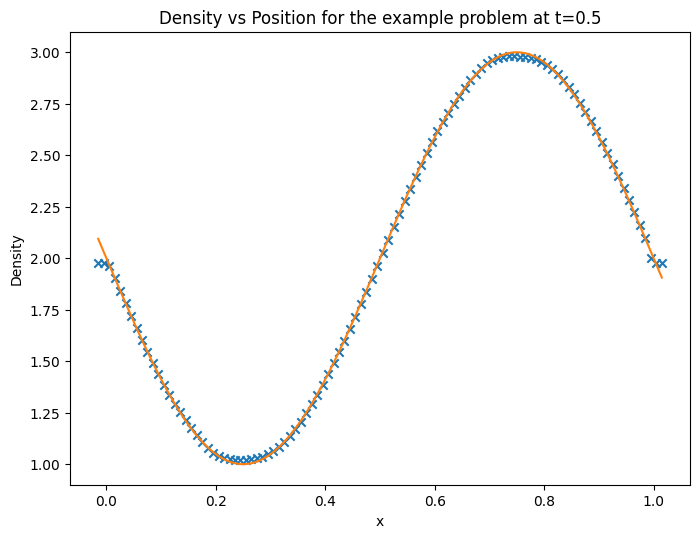

In [60]:
v = FluidVars()
plt.scatter(g.x, U[:,v.urho], marker="x", color="C0")
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Density vs Position for the example problem at t=0.5')
plt.plot(g.x, 2 + np.sin( 2* np.pi * (g.x - tm)), color='C1')

## Sod's Problem

In [61]:
def sod(grid):
    
    v = FluidVars()
    U = grid.scratch_array(nc=v.nvar)
    
    # setup initial conditions -- this is Sod's problem
    rho_l = 1.0
    u_l = 0.0
    p_l = 1.0
    rho_r = 0.125
    u_r = 0.0
    p_r = 0.1

    idx_l = grid.x < 0.5
    idx_r = grid.x >= 0.5

    U[idx_l, v.urho] = rho_l
    U[idx_l, v.umx] =  rho_l * u_l
    U[idx_l, v.uener] = p_l/(v.gamma - 1.0) + 0.5 * rho_l * u_l**2

    U[idx_r, v.urho] = rho_r
    U[idx_r, v.umx] =  rho_r * u_r
    U[idx_r, v.uener] = p_r/(v.gamma - 1.0) + 0.5 * rho_r * u_r**2
    
    return U

In [62]:
g, U = mol_solve(100, tmax=0.2, init_cond=sod)

In [63]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [8, 6]

In [64]:
sod = np.genfromtxt("sod-exact.out", skip_header=2, names=True) # This file contains the exact solution for Sod Problem

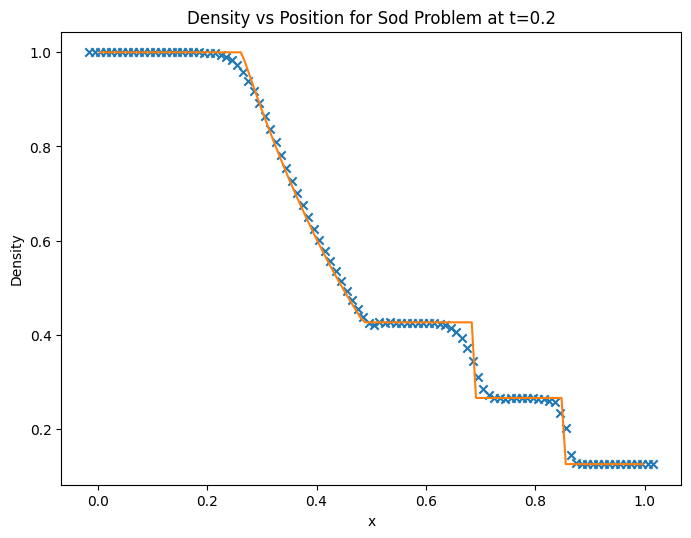

In [65]:
v = FluidVars()
plt.scatter(g.x, U[:,v.urho], marker="x", color="C0")
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Density vs Position for Sod Problem at t=0.2')
plt.plot(sod["x"], sod["rho"], color="C1")

## Lax problem


In [66]:
def lax(grid):
    
    v = FluidVars()
    U = grid.scratch_array(nc=v.nvar)
    
    # setup initial conditions -- this is lax's problem
    rho_l = 0.445
    u_l = 0.698
    p_l = 3.528
    rho_r = 0.5
    u_r = 0.0
    p_r = 0.571

    idx_l = grid.x < 0.5
    idx_r = grid.x >= 0.5

    U[idx_l, v.urho] = rho_l
    U[idx_l, v.umx] =  rho_l * u_l
    U[idx_l, v.uener] = p_l/(v.gamma - 1.0) + 0.5 * rho_l * u_l**2

    U[idx_r, v.urho] = rho_r
    U[idx_r, v.umx] =  rho_r * u_r
    U[idx_r, v.uener] = p_r/(v.gamma - 1.0) + 0.5 * rho_r * u_r**2
    
    return U

In [67]:
g, U = mol_solve(100, tmax=0.13, init_cond=lax)

In [68]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [8, 6]

In [69]:
# lax = np.genfromtxt("lax-exact.out", skip_header=2, names=True)

Text(0.5, 1.0, 'Density vs Position for Lax Problem at t=0.13')

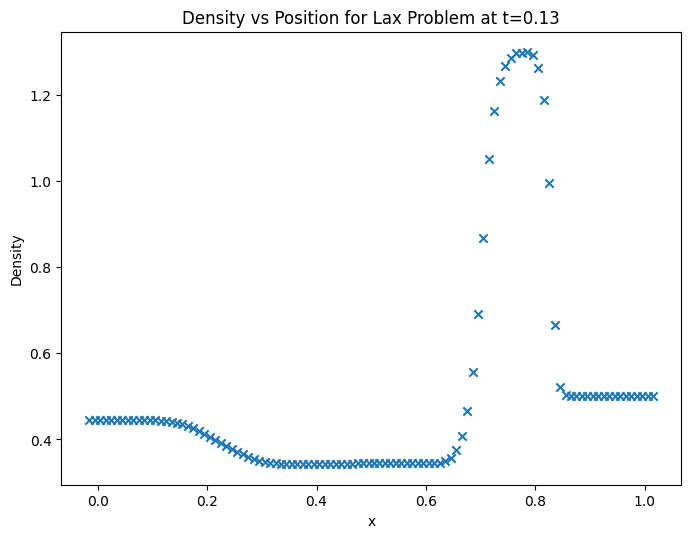

In [70]:
v = FluidVars()
plt.scatter(g.x, U[:,v.urho], marker="x", color="C0")
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Density vs Position for Lax Problem at t=0.13')
# plt.plot(lax["x"], lax["rho"], color="C1")

## Strong Shock Problem
 In this test, the center of the domain is evacuated as two rarefaction waves propagate in each direction, outward from the center. It is difficult to get the internal energy to behave at the center of the domain because we are creating a vacuum. 

In [71]:
def StrongShock(grid):
    
    v = FluidVars()
    U = grid.scratch_array(nc=v.nvar)
    
    # setup initial conditions -- this is StrongShock's problem
    rho_l = 1.0
    u_l = 0.0
    p_l = 1000.0
    rho_r = 1.0
    u_r = 0.0
    p_r = 0.01

    idx_l = grid.x < 0.5
    idx_r = grid.x >= 0.5

    U[idx_l, v.urho] = rho_l
    U[idx_l, v.umx] =  rho_l * u_l
    U[idx_l, v.uener] = p_l/(v.gamma - 1.0) + 0.5 * rho_l * u_l**2

    U[idx_r, v.urho] = rho_r
    U[idx_r, v.umx] =  rho_r * u_r
    U[idx_r, v.uener] = p_r/(v.gamma - 1.0) + 0.5 * rho_r * u_r**2
    
    return U

In [72]:
g, U = mol_solve(100, tmax=0.012, init_cond=StrongShock)

Text(0.5, 1.0, 'Density vs Position for Strong Shock Problem at t=0.012')

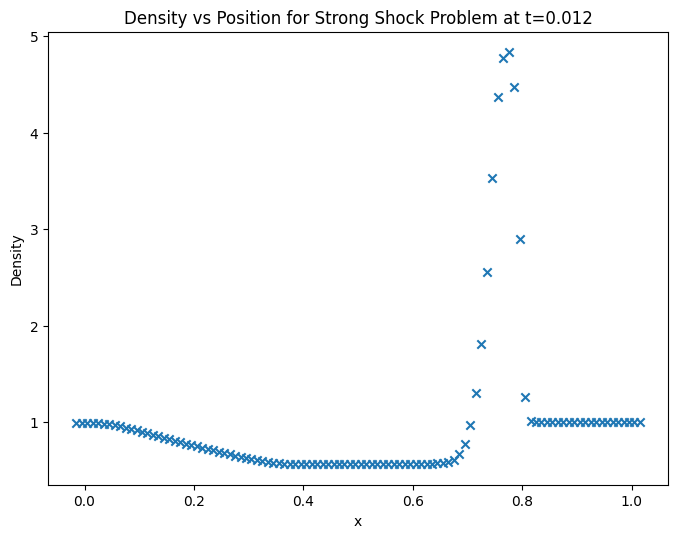

In [73]:
v = FluidVars()
plt.scatter(g.x, U[:,v.urho], marker="x", color="C0")
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Density vs Position for Strong Shock Problem at t=0.012')

## Woodward and Colella Problem

In [74]:
def WAC(grid):
    
    v = FluidVars()
    U = grid.scratch_array(nc=v.nvar)
    
    # setup initial conditions -- this is WAC's problem
    rho_l = 1.0
    u_l = 0.0
    p_l = 0.01
    rho_r = 1.0
    u_r = 0.0
    p_r = 100.0

    idx_l = grid.x < 0.5
    idx_r = grid.x >= 0.5

    U[idx_l, v.urho] = rho_l
    U[idx_l, v.umx] =  rho_l * u_l
    U[idx_l, v.uener] = p_l/(v.gamma - 1.0) + 0.5 * rho_l * u_l**2

    U[idx_r, v.urho] = rho_r
    U[idx_r, v.umx] =  rho_r * u_r
    U[idx_r, v.uener] = p_r/(v.gamma - 1.0) + 0.5 * rho_r * u_r**2
    
    return U

In [75]:
g, U = mol_solve(100, tmax=0.035, init_cond=WAC)

Text(0.5, 1.0, 'Density vs Position for Woodward and Colella Problem at t=0.035')

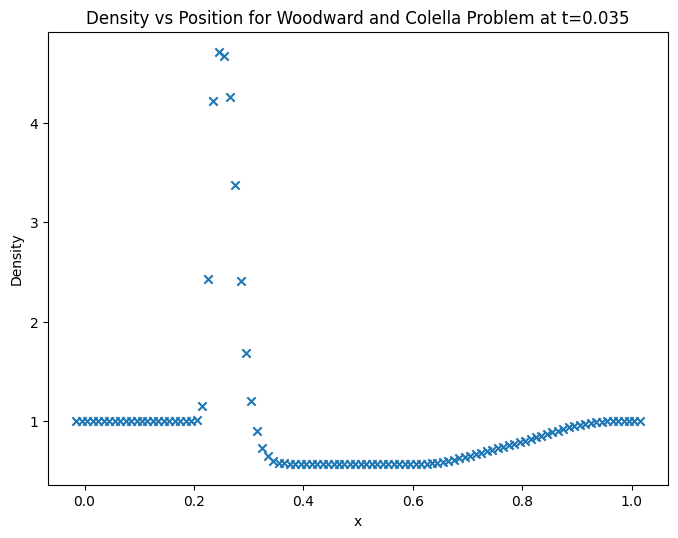

In [76]:
v = FluidVars()
plt.scatter(g.x, U[:,v.urho], marker="x", color="C0")
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Density vs Position for Woodward and Colella Problem at t=0.035')